In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')
from matplotlib import rc
rc('text', usetex=True)
import seaborn as sns


import sys, re, time, json
from PSlim import Experiment, get_eps, ROC, ROCAUC

pyslurm = '/home/enes/pyslurm/'
#pyslurm = None

In [2]:
Train = False # False if you do analysis with given simulations and estimates

In [3]:
if pyslurm:
    sys.path.append(pyslurm)
    from pyslurm import Slurm

    slurm = Slurm(account='stats_dept1')

    srun = slurm.batch('source activate slim', 
                       '#time=0-1:00:00',
                       '#mem=1000M',
                       '#mem-per-cpu=None', 
                       '#job-name="sim"')   

    srun_est = slurm.batch('module load python3.8-anaconda/2020.07', 
                           '#mem-per-cpu=300',
                           '#job-name="est"',
                           '#cpus-per-task=3')

### Parameters:

In [4]:
N = 50
Ne = 10000
L = 100000
r = 1.25e-8
mu = 2.5e-8

extmut = 0 # no extra mutation (just one)
Until = 100000 # make sure model runs until it reaches the desired frequency Until>>Ne
h = 0.5

Args = {}

Args['Fn'] = {'Simulator':'slim', 'slimTxt':'Slim.txt', 
              'N':N, 'Ne':Ne, 'L':L, 'r':r, 'mu':mu, 
              's':0, 'h':0.5, 'extmut':0, 'reset_lost': 0,
              'Until':Ne, 'Freq':0.25, 'rep':0, 
              'srun':srun, 'srun_est':srun_est,
              'etapath':'etas/Fn.json', 'start': Until + 100,
              'name':'Neutral Model'}

for s in [0.02, 0.01, 0.003, 0.001]:
    for Freq in [0.25, 0.5, 0.75]:
        name = 's='+str(s)+'F='+str(Freq)
        arg = Args['Fn'].copy()
        arg['s'] = s
        arg['Freq'] = Freq
        arg['Until'] = 300000
        arg['name'] = name
        arg['reset_lost'] = 1
        Args[name] = arg

In [5]:
cID = 3 # simulation class id for directional selection constant pop size simulations
nrep = 250
X = Experiment(cID, nrep, Args)

## 1 Simulation

In [10]:
if Train:
    X.sim()

## 2 Population Size History estimation

In [11]:
X.calc_sfs()
X.train_eta()

Done!


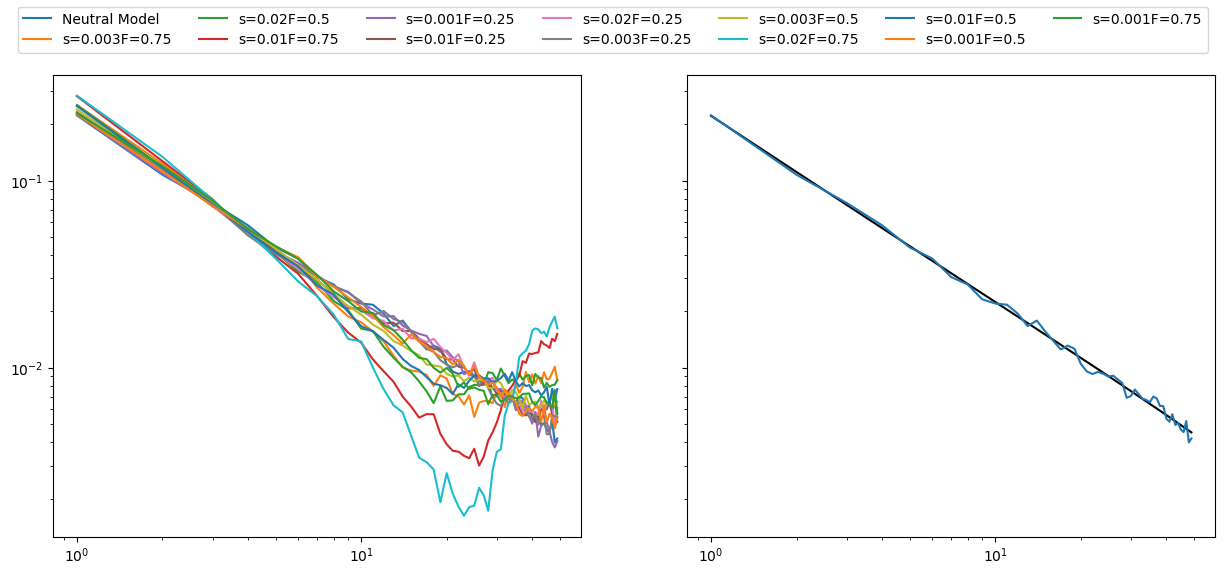

In [12]:
fig, ax = plt.subplots(1,2,figsize = (15,6), sharex=True, sharey=True)

for setid in X.neutrals:
    name = Args[setid]['name']
    ax[1].plot(range(1, len(X.AFS[setid])+1), X.ebl[setid]/X.ebl[setid].sum(), color = 'black')
    ax[1].plot(range(1, len(X.AFS[setid])+1), X.AFS[setid]/X.AFS[setid].sum())
    ax[0].plot(range(1, len(X.AFS[setid])+1), X.AFS[setid]/X.AFS[setid].sum(), label = name)

for setid in set(X.setids).difference(X.neutrals):
    name = Args[setid]['name']
    ax[0].plot(range(1, len(X.AFS[setid])+1), X.AFS[setid]/X.AFS[setid].sum(), label = name)

ax[1].set_xscale('log')
ax[1].set_yscale('log')
fig.legend(ncol = 7, loc = 'upper center')

## 3 Optimizing $\beta$-imbalance and calculating summary stats

In [13]:
BIM = '/nfs/turbo/lsa-enes/bim/bim/BIM.py'

treew = 'split'

if Train:
    for setid in X.setids:
        X.est(BIM, setid, now = 10, srun = srun_est, arg = '--r2t=0.005 --r2s=0.001 --treew='+treew)

If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!


In [17]:
if Train:
    for setid in X.setids:
        X.merge_outs(setid)

## 4 Analysis

In [6]:
stats = ['bsfs', 'TajD', 'ibtree', 'iColless', 'iOmega']

### ROC Curves

In [7]:
# myorder = [2, 3, 4, 0, 1]
myorder = [0, 1, 2, 3, 4]

In [12]:
X.setids

['Fn',
 's=0.02F=0.25',
 's=0.02F=0.5',
 's=0.02F=0.75',
 's=0.01F=0.25',
 's=0.01F=0.5',
 's=0.01F=0.75',
 's=0.003F=0.25',
 's=0.003F=0.5',
 's=0.003F=0.75',
 's=0.001F=0.25',
 's=0.001F=0.5',
 's=0.001F=0.75']

In [42]:
df = pd.read_csv(X.df['Fn']).dropna()
n = df.shape[0]
for stat in stats:
    
    s = df[stat]
    
    
    p = np.mean(np.abs((s-s.mean())/s.std())>1.96)
    #print(stat, p)
    print(stat, np.sqrt(p*(1-p)/n))

bsfs 0.015479534876733215
TajD 0.01351976331153767
ibtree 0.01351976331153767
iColless 0.012971353052014273
iOmega 0.014541526742402257


In [ ]:
pd.read_csv(X.df[k1]).dropna()

In [8]:
fprs = {}
tprs = {}
aucs = {}
blds = {}

for s in [0.02, 0.01, 0.003, 0.001]:   
    Vs = [['Fn', 's='+str(s)+'F='+str(F)] for F in [0.25,0.5,0.75]]
    names = ['Neutral Model vs $s='+str(s)+'$ \& $F='+str(F)+'$' for F in [0.25,0.5,0.75]]

    for name, vs in zip(names, Vs):
        k1, k2 = vs
        df1 = pd.read_csv(X.df[k1]).dropna()
        df2 = pd.read_csv(X.df[k2]).dropna()
        
        for pos in ['iColless', 'FulD']:
            df1[pos] = -df1[pos]
            df2[pos] = -df2[pos]
        
        max_auc = 0
        for key in stats:
            
            fpr, tpr, auc = ROCAUC(df1[key], df2[key], score_ascending = False)
            
            fprs[key, name] = fpr
            tprs[key, name] = tpr
            aucs[key, name] = auc
            
            if auc>max_auc:
                blds[name] = key
                max_auc = auc    

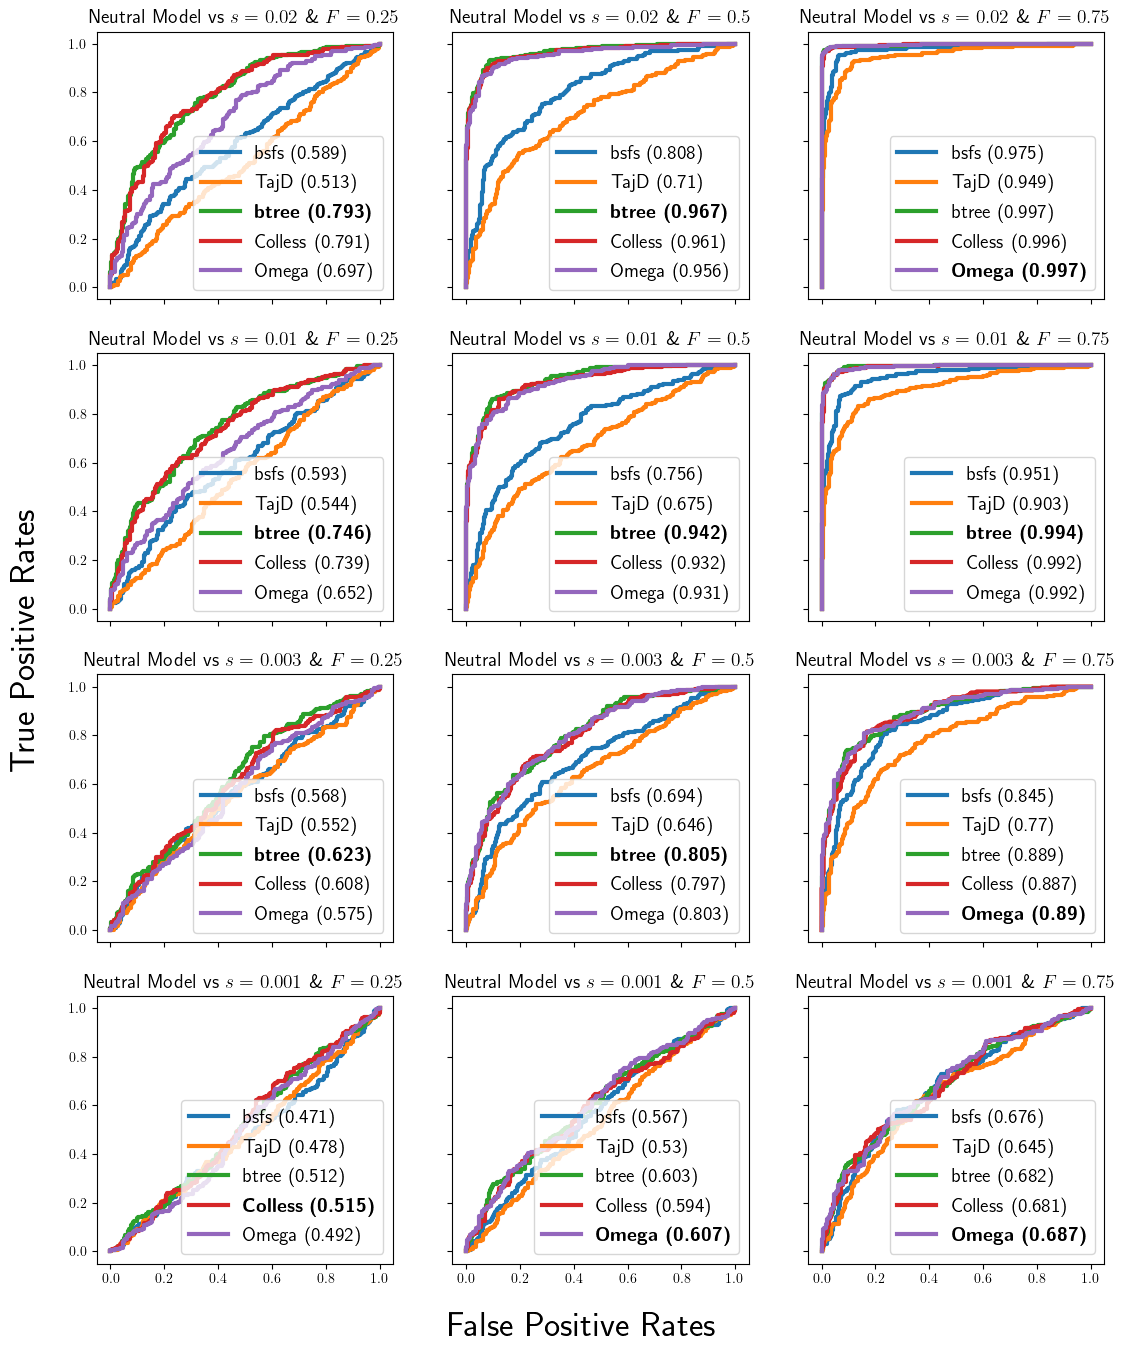

In [47]:
fig, ax = plt.subplots(4,3,figsize = (13,16), sharex = True, sharey = True)

for i, name in enumerate(blds):
    c, r = i%3, i//3
    
    for key in stats:
        fpr = fprs[key, name]
        tpr = tprs[key, name]
        auc = aucs[key, name]
        
        if key == 'ibtree':
            label = 'btree'
        elif key == 'iColless':
            label = 'Colless'
        elif key == 'iOmega':
            label = 'Omega'
        else:
            label = key
        
        label = label + ' ('+str(round(auc, 3))+')'      
        
        if blds[name] == key:
            label = r"\textbf{"+label+"}"
        
        ax[r, c].plot(fpr, tpr, label = label, linewidth = 3)
        
    ax[r, c].set_title(name, size = 14)
    
    ax[r, c].legend()
    handles, labels = ax[r,c].get_legend_handles_labels()
    ax[r, c].legend([handles[_] for _ in myorder], [labels[_] for _ in myorder], loc = 'lower right',
                   prop={'size': 14})

fig.text(0.5, 0.07, 'False Positive Rates', ha='center', va='center', size = 25)
fig.text(0.07, 0.5, 'True Positive Rates', rotation = 90, ha='center', va='center', size = 25)
plt.savefig('plots/Constant_Directional.pdf', dpi = 600, bbox_inches = 'tight')

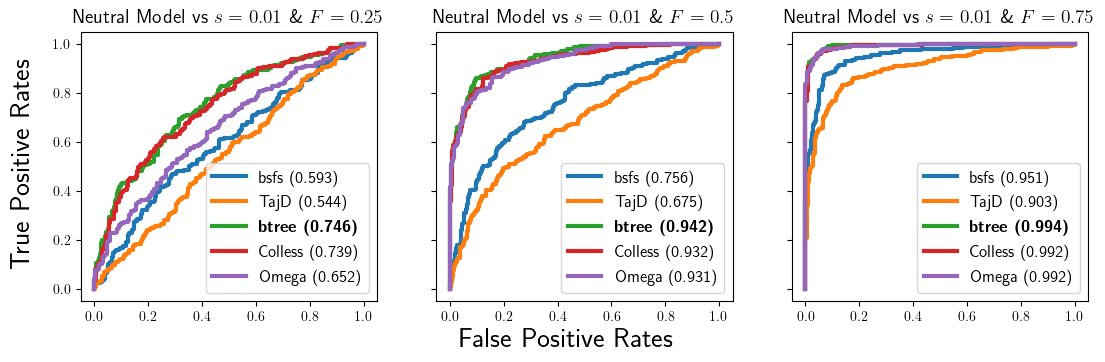

In [48]:
fig, ax = plt.subplots(1,3, figsize = (13,3.5), sharex = True, sharey = True)

for i, name in enumerate(list(blds.keys())[3:6]):
    
    for key in stats:
        fpr = fprs[key, name]
        tpr = tprs[key, name]
        auc = aucs[key, name]
        
        if key == 'ibtree':
            label = 'btree'
        elif key == 'iColless':
            label = 'Colless'
        elif key == 'iOmega':
            label = 'Omega'
        else:
            label = key
        
        label = label + ' ('+str(round(auc, 3))+')'      
        
        if blds[name] == key:
            label = r"\textbf{"+label+"}"
        
        ax[i].plot(fpr, tpr, label = label, linewidth = 3)
        
    ax[i].set_title(name, size = 14)
    
    ax[i].legend()
    handles, labels = ax[i].get_legend_handles_labels()
    ax[i].legend([handles[_] for _ in myorder], [labels[_] for _ in myorder], loc = 'lower right',
                   prop={'size': 12})

fig.text(0.5, 0.00, 'False Positive Rates', ha='center', va='center', size = 20)
fig.text(0.08, 0.5, 'True Positive Rates', rotation = 90, ha='center', va='center', size = 20)
plt.savefig('plots/Constant_Directional_maintext.pdf', dpi = 600, bbox_inches = 'tight')

In [17]:
from scipy.stats import wilcoxon
aucs = pd.DataFrame({key: [aucs[i] for i in aucs.keys() if i[0] == key] for key in stats})

In [18]:
wilcoxon(aucs['bsfs'], aucs['TajD'], alternative = 'greater')[1], (aucs['bsfs']-aucs['TajD']).mean()

(0.0014367069639262613, 0.04826400000000001)

In [19]:
wilcoxon(aucs['ibtree'], aucs['iColless'], alternative = 'greater')[1], (aucs['ibtree']-aucs['iColless']).mean()

(0.004816487886294337, 0.005083333333333329)

In [20]:
wilcoxon(aucs['ibtree'], aucs['iOmega'], alternative = 'greater')[1], (aucs['ibtree']-aucs['iOmega']).mean()

(0.02493010187845347, 0.022651999999999988)